In [1]:
import matplotlib.pyplot as plt

from PIL import Image

In [2]:
# 구글드라이브에서 데이터 로드
annotation_path = '/content/drive/MyDrive/pytorch/annotations.tar.gz'
image_path = '/content/drive/MyDrive/pytorch/images.tar.gz'


In [ ]:
!tar -xvzf '/content/drive/MyDrive/pytorch/annotations.tar.gz'

In [ ]:
!tar -xvzf '/content/drive/MyDrive/pytorch/images.tar.gz'

In [5]:
from glob import glob

In [6]:

annotation_list = glob('/content/annotations/trimaps/*.png')
img_list = glob('/content/images/*.jpg')

In [7]:
# 어노테이션, 이미지 찾는다
annotation_list = sorted(annotation_list)
img_list = sorted(img_list)

In [8]:
# 정렬된 데이터가 서로 쌍이 맞는지 확인
temp1 = [data.split('/')[-1].split('.')[0] for data in annotation_list]
temp2 = [data.split('/')[-1].split('.')[0] for data in img_list]
sum(map( lambda x,y : x != y, temp1,temp2 ))

0

In [9]:
annotation_list[0]

'/content/annotations/trimaps/Abyssinian_1.png'

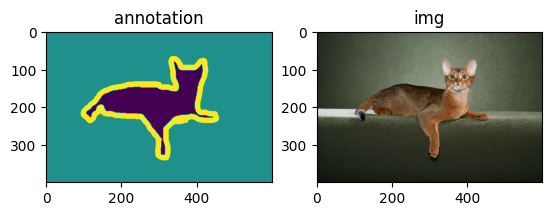

In [10]:
from PIL import Image
plt.subplot(1, 2, 1)
plt.title("annotation")
annotation = Image.open(annotation_list[0])
plt.imshow(annotation)


img = Image.open(img_list[0])
plt.subplot(1, 2, 2)
plt.title("img")
plt.imshow(img)

In [11]:
# 이미지처리
# 어떤이미지가 어디에 있는지 예측하는 객체탐지
# 이미지의 모든 픽셀을 분류하는 이미지 세그멘테이션
# 이미지에 섞인 노이즈를 걸러 흐린 이미지를 선명하게 하는 디노이징

# 이미지세그먼테이션 이미지 디노이징 모델은 정보를 압축하는 인코더와 정보로부터 이미지를 복원하는 디코더로 구성

# 인코더 - 디코더의 대표적인 모델이 U-Net


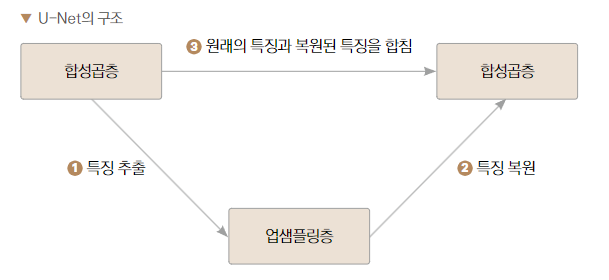

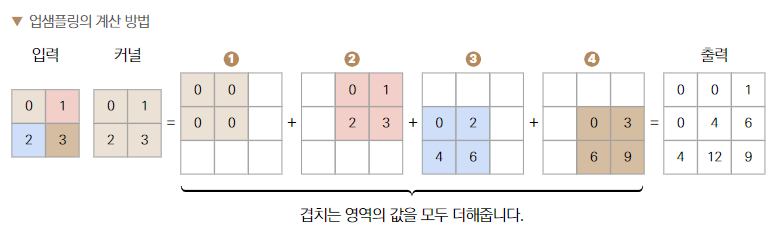

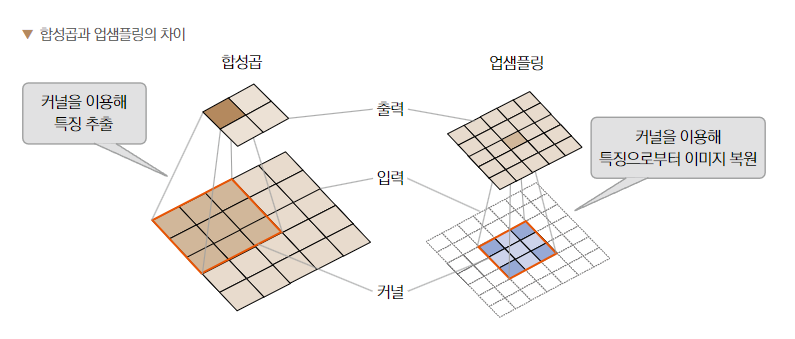

학습용 데이터 만들기


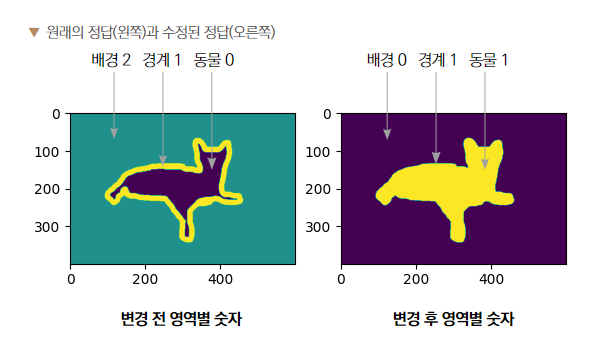

In [12]:
import torch
import numpy as np
from torch.utils.data.dataset import Dataset
from PIL import Image

array([[[ 24,  29,  27],
        [ 25,  30,  28],
        [ 23,  30,  27],
        ...,
        [145, 168, 184],
        [141, 166, 182],
        [148, 174, 190]],

       [[ 28,  32,  27],
        [ 24,  29,  27],
        [ 22,  29,  26],
        ...,
        [145, 168, 184],
        [140, 165, 181],
        [147, 173, 189]],

       [[ 28,  32,  27],
        [ 26,  30,  25],
        [ 23,  28,  26],
        ...,
        [145, 168, 184],
        [140, 165, 181],
        [146, 172, 188]],

       ...,

       [[ 31,  45,  44],
        [ 29,  41,  41],
        [ 30,  41,  39],
        ...,
        [102, 128, 140],
        [100, 126, 138],
        [107, 133, 145]],

       [[ 21,  34,  32],
        [ 21,  32,  30],
        [ 23,  31,  30],
        ...,
        [101, 124, 139],
        [104, 127, 142],
        [113, 136, 151]],

       [[ 42,  53,  51],
        [ 43,  51,  50],
        [ 47,  53,  52],
        ...,
        [108, 128, 145],
        [111, 131, 148],
        [125, 145, 162]]], dtype=uint8)
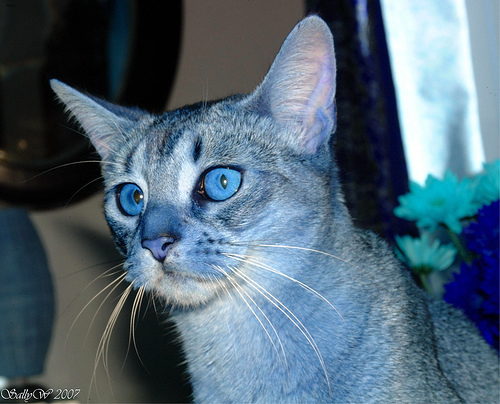

In [13]:
# 이미지 크기 확인
import cv2
cv2.imread(img_list[10])

In [104]:
import glob
import torch
import numpy as np

from torch.utils.data.dataset import Dataset
from PIL import Image


class Pets(Dataset):
   def __init__(self, path_to_img,
                path_to_anno,
                train=True,
                transforms=None,
                input_size=(128, 128)):

       # ❶ 정답과 입력 이미지를 이름순으로 정렬
       self.images = sorted(glob.glob(path_to_img+"/*.jpg"))
       self.annotations = sorted(glob.glob(path_to_anno + "/*.png"))


       # ❷ 데이터셋을 학습과 평가용으로 나눔
       self.X_train = self.images[:int(0.8 * len(self.images))]
       self.X_test = self.images[int(0.8 * len(self.images)):]
       self.Y_train = self.annotations[
                :int(0.8 * len(self.annotations))]
       self.Y_test = self.annotations[
                int(0.8 * len(self.annotations)):]

       self.train = train  # 학습용 데이터 평가용 데이터 결정 여부
       self.transforms = transforms  # 사용할 데이터 증강
       self.input_size = input_size  # 입력 이미지 크기
   def __len__(self):  # 데이터 개수를 나타냄
       if self.train:
           return len(self.X_train)  # 학습용 데이터셋 길이
       else:
           return len(self.X_test)   # 평가용 데이터셋 길이
   def preprocess_mask(self, mask):  # ➋ 정답을 변환해주는 함수
       mask = mask.resize(self.input_size)
       mask = np.array(mask).astype(np.float32)
       mask[mask != 2.0] = 1.0
       mask[mask == 2.0] = 0.0
       mask = torch.tensor(mask)
       return mask
   def __getitem__(self, i):  # i번째 데이터와 정답을 반환
    if self.train:  # 학습용 데이터
      X_train = Image.open(self.X_train[i])
      X_train = self.transforms(X_train)
      Y_train = Image.open(self.Y_train[i])
      Y_train = self.preprocess_mask(Y_train)

      return X_train, Y_train

    else:  # 평가용 데이터
      X_test = Image.open(self.X_test[i])
      X_test = self.transforms(X_test)
      Y_test = Image.open(self.Y_test[i])
      Y_test = self.preprocess_mask(Y_test)
      return X_test, Y_test


In [105]:
# 모델 정의
  # Conv2D 특징을 추출하면 , ConvTranspose2D() 업샘플링  최종출력은 0~1사이의 값을 가지는 1채널 이미지 - squezze() 함수를 이용해서 채널차원 제거

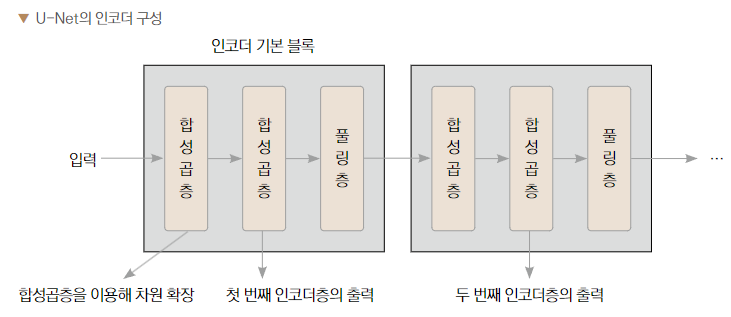

U-Net 모델 정의

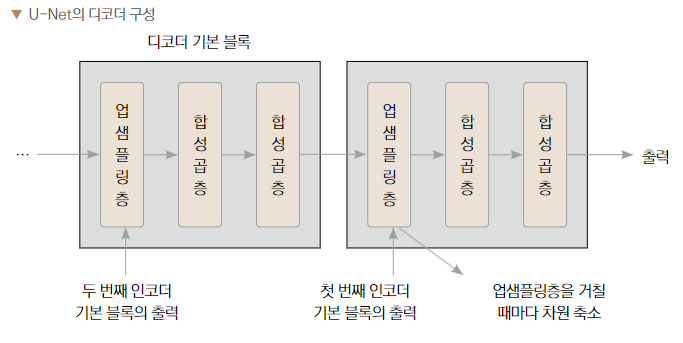

In [106]:
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # 인코더
        self.enc1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.enc1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.enc3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.enc4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc5_1 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.enc5_2 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)

        # 디코더
        self.upsample4 = nn.ConvTranspose2d(512, 512, 2, stride=2)
        self.dec4_1 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.dec4_2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)

        self.upsample3 = nn.ConvTranspose2d(256, 256, 2, stride=2)
        self.dec3_1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.dec3_2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)

        self.upsample2 = nn.ConvTranspose2d(128, 128, 2, stride=2)
        self.dec2_1 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.dec2_2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)

        self.upsample1 = nn.ConvTranspose2d(64, 64, 2, stride=2)
        self.dec1_1 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.dec1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.dec1_3 = nn.Conv2d(64, 1, kernel_size=1)

        # 활성화 함수
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.relu(self.enc1_1(x))
        x1 = self.relu(self.enc1_2(x1))
        x2 = self.pool1(x1)

        x2 = self.relu(self.enc2_1(x2))
        x2 = self.relu(self.enc2_2(x2))
        x3 = self.pool2(x2)

        x3 = self.relu(self.enc3_1(x3))
        x3 = self.relu(self.enc3_2(x3))
        x4 = self.pool3(x3)

        x4 = self.relu(self.enc4_1(x4))
        x4 = self.relu(self.enc4_2(x4))
        x5 = self.pool4(x4)

        x5 = self.relu(self.enc5_1(x5))
        x5 = self.relu(self.enc5_2(x5))

        x = self.upsample4(x5)
        x = torch.cat([x, x4], dim=1)
        x = self.relu(self.dec4_1(x))
        x = self.relu(self.dec4_2(x))

        x = self.upsample3(x)
        x = torch.cat([x, x3], dim=1)
        x = self.relu(self.dec3_1(x))
        x = self.relu(self.dec3_2(x))

        x = self.upsample2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.relu(self.dec2_1(x))
        x = self.relu(self.dec2_2(x))

        x = self.upsample1(x)
        x = torch.cat([x, x1], dim=1)
        x = self.relu(self.dec1_1(x))
        x = self.relu(self.dec1_2(x))
        x = self.dec1_3(x)

        x = torch.squeeze(x, dim=1)
        return x


모델 학습하기

In [107]:
import tqdm

from torchvision.transforms import Compose
from torchvision.transforms import ToTensor, Resize
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"


# 데이터 전처리 정의
transform = Compose([
   Resize((128, 128)),
   ToTensor()
])

In [108]:
path_to_image = '/content/images'
path_to_annotation = '/content/annotations/trimaps'
# 학습 데이터
train_set = Pets(path_to_img=path_to_image,
                 path_to_anno=path_to_annotation,
                 transforms=transform)

# 평가용 데이터
test_set = Pets(path_to_img=path_to_image,
                path_to_anno=path_to_annotation,
                transforms=transform,
                train=False)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set)

In [109]:
# 모델 정의
model = UNet().to(device)


# 학습률 정의
learning_rate = 0.0001

# 최적화 정의
optim = Adam(params=model.parameters(), lr=learning_rate)


In [ ]:
for epoch in range(200):
  iterator = tqdm.tqdm(train_loader)
  try:
    for data, label in iterator:
      optim.zero_grad()  # 이전 루프의 기울기 초기화

      preds = model(data.to(device))  # 모델의 예측값 출력
      loss = nn.BCEWithLogitsLoss()(
          preds,
          label.type(torch.FloatTensor).to(device))  # 손실 계산
      loss.backward()  # 오차 역전파

      optim.step()  # 최적화

      iterator.set_description(f"epoch{epoch+1} loss:{loss.item()}")
  except RuntimeError as e:
    print(e)

torch.save(model.state_dict(), "./UNet.pth")  # 모델 가중치 저장

In [96]:
try:
  for data, label in train_loader:
    print(f'정상:{data.shape, label.shape}')
except RuntimeError as e:
  print(data.shape, label.shape)
  print(e)

정상:(torch.Size([32, 3, 128, 128]), torch.Size([32, 128, 128]))
torch.Size([32, 3, 128, 128]) torch.Size([32, 128, 128])
stack expects each tensor to be equal size, but got [3, 128, 128] at entry 0 and [1, 128, 128] at entry 3


In [46]:
import matplotlib.pylab as plt

model.load_state_dict(torch.load('./UNet.pth', map_location='cpu'))
data, label = test_set[1]
pred = model(torch.unsqueeze(data.to(device), dim=0)) > 0.5
with torch.no_grad():
  plt.subplot(1,2,1)
  plt.title("Predicted")
  plt.imshow(pred)
  plt.subplot(1,2,2)
  plt.title("Real")
  plt.imshow(label)
  plt.show()